# Predicting Minecraft Server Subscription from Player Behaviour

## Introduction

Many online games use a hybrid business model where users can play for free but may optionally pay for premium features or subscriptions. Understanding which players are most likely to subscribe is valuable for both server administrators and game developers: it can inform marketing strategies, server design, and allocation of limited development resources.

In this project, we use data from a Minecraft research server to investigate which kinds of players are more likely to subscribe to the server. The main focus is on how demographic and play-related characteristics are associated with the probability of subscription.

### Research Question

**Can we predict whether a player will subscribe to the Minecraft research server from their demographic characteristics and in-game behaviour (such as experience level, play time, and number of sessions)?**

We treat subscription status as the outcome (response) and use a set of player-level features as predictors. We then build and evaluate a k-nearest neighbours (KNN) classification model to answer this question.

### Dataset

We use two datasets collected from a Minecraft research server:

1. **`players.csv` (player-level data)**  
   Each row represents a unique player. Key variables include:
   - `experience` (categorical): self-reported Minecraft experience level (`"Pro"`, `"Veteran"`, `"Regular"`, `"Amateur"`).
   - `subscribe` (logical): whether the player subscribed to the server (`TRUE` / `FALSE`). This is our **response variable**.
   - `hashedEmail` (character): anonymized player identifier used to link with the sessions dataset.
   - `played_hours` (numeric): total hours the player spent on the server.
   - `name` (character): player’s first name (not used in the analysis).
   - `gender` (categorical): player’s gender.
   - `Age` (numeric): player’s age in years.

   The dataset contains **196 observations** and **7 variables**.

2. **`sessions.csv` (session-level data)**  
   Each row contains information about a single play session on the server. Important variables include:
   - `hashedEmail` (character): player ID, linking sessions to `players.csv`.
   - Additional session fields (such as timestamps or durations), which we use indirectly by aggregating number of sessions per player.

By joining these two datasets on `hashedEmail`, we obtain a player-level dataset with both demographics and behavioural information (e.g., number of sessions).

In the following sections, we describe our methods, present exploratory summaries and visualizations, fit a KNN classifier, and interpret its performance in the context of our research question.


## Methods & Results

In [27]:
library(tidyverse)
library(tidymodels)

players_url <- "https://raw.githubusercontent.com/ishirGhatpande/Individual-Project-Planning/refs/heads/main/players.csv"
players <- read_csv(players_url)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [28]:
#cleaning data
players <- players |>
    rename(age = Age) |> 
    select(subscribe, played_hours, age) |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Subscribed" = "TRUE", "Not Subscribed" = "FALSE")) |>
    na.omit()
head(players)

subscribe,played_hours,age
<fct>,<dbl>,<dbl>
Subscribed,30.3,9
Subscribed,3.8,17
Not Subscribed,0.0,17
Subscribed,0.7,21
Subscribed,0.1,21
Subscribed,0.0,17


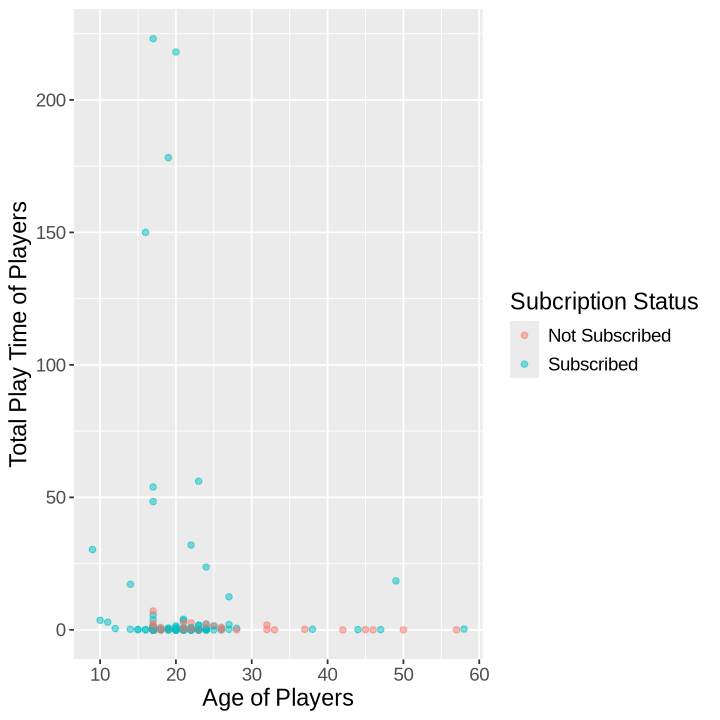

In [30]:
#visualizing the data
age_hours <- players |>
    ggplot(aes(x = age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age of Players", y = "Total Play Time of Players", color = "Subcription Status") +
    theme(text = element_text(size = 14)) 
age_hours

#### Figure 1: 

In [31]:
#performing k-nn classification
set.seed(1234) #setting the seed allows code to be fully reproducible

#splitting the data, 80% to training set and 20% to testing set
players_split <- initial_split(players, prop = 0.8, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

#creating the recipe + preprocessing steps
knn_recipe <- recipe(subscribe ~ age + played_hours, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

#model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#tuning the model to find the best k value, started out from 1 to 100 by 5, graph showed plateau past ~30,
#so we changed from 1 to 35 by 1
# **haven't actually made the change above yet
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

 players_fit <- workflow() |>
     add_recipe(knn_recipe) |>
     add_model(knn_spec) |>
     tune_grid(resamples = players_vfold, grid = k_vals) |>
     collect_metrics() 

players_results <- players_fit |> filter(.metric == "accuracy")
players_results

# after evaluating on test set, make sure to evaluate model performance by calculating 
# precision, recall, and the confusion matrix from the predictions made on the test set

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4546237,5,0.022435272,Preprocessor1_Model01
6,accuracy,binary,0.5920565,5,0.029537742,Preprocessor1_Model02
11,accuracy,binary,0.6811828,5,0.032540875,Preprocessor1_Model03
16,accuracy,binary,0.7142876,5,0.011641438,Preprocessor1_Model04
21,accuracy,binary,0.7405242,5,0.007788570,Preprocessor1_Model05
26,accuracy,binary,0.7405242,5,0.007788570,Preprocessor1_Model06
31,accuracy,binary,0.7338575,5,0.004238477,Preprocessor1_Model07
36,accuracy,binary,0.7338575,5,0.004238477,Preprocessor1_Model08
41,accuracy,binary,0.7338575,5,0.004238477,Preprocessor1_Model09


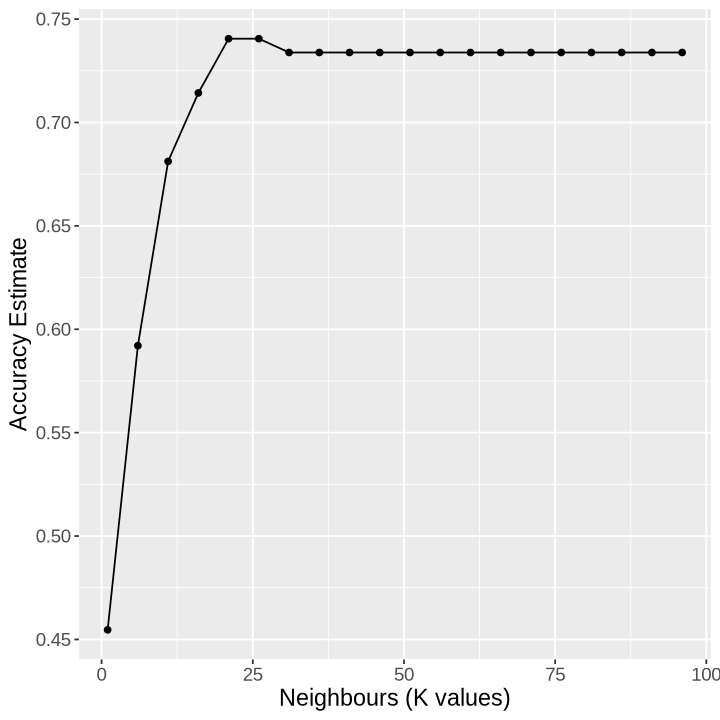

In [32]:
#visualizing the accuracy vs. k
options(repr.plot.height = 6, repr.plot.width = 6)
accuracy_vs_k <- players_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours (K values)", y = "Accuracy Estimate") +
    theme(text = element_text(size = 14))
accuracy_vs_k

In [33]:
#identifying the best k
best_k <- players_results |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

#the cross validation accuracy estimate of k = 21
best_k_accuracy <- players_results |>
    filter(neighbors == 21) |>
    pull(mean)
best_k_accuracy

[1] 21

[1] 0.7405242